In [1]:
!pip3 install cloudmesh-installer
!pip3 install cloudmesh-common

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, SimpleRNN, InputLayer, LSTM, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import boston_housing
from cloudmesh.common.StopWatch import StopWatch
import pandas as pd

print(tf.__version__)

2.4.1


## Data Load

In [3]:
StopWatch.start("data-load")
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()
StopWatch.stop("data-load")

## Data Pre-Process

In [4]:
# Shuffle the training set
StopWatch.start("data-pre-process")
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

print(train_data[0])  # Display sample features, notice the different scales

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

# Test data is *not* used when calculating the mean and std.

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
StopWatch.stop("data-pre-process")


print(train_data[0])  # First training sample, normalized


Training set: (404, 13)
Testing set:  (102, 13)
[2.2438e-01 0.0000e+00 9.6900e+00 0.0000e+00 5.8500e-01 6.0270e+00
 7.9700e+01 2.4982e+00 6.0000e+00 3.9100e+02 1.9200e+01 3.9690e+02
 1.4330e+01]
[-0.38147358 -0.48361547 -0.20791668 -0.25683275  0.23597582 -0.33866379
  0.38304781 -0.61255141 -0.39603557 -0.08965908  0.32944629  0.44807713
  0.21933197]


## Create the model

In [5]:
StopWatch.start("compile")
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, 
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  # optimizer = tf.train.RMSPropOptimizer(0.001)
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
  
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()
StopWatch.stop("compile")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


##Train the model

In [6]:
StopWatch.start("train")
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])
StopWatch.stop("train")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

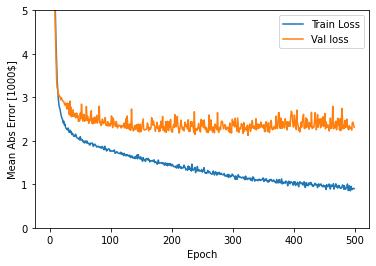

In [7]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mae']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label ='Val loss')
  plt.legend()
  plt.ylim([0,5])

plot_history(history)


....................................................................................................
..............................

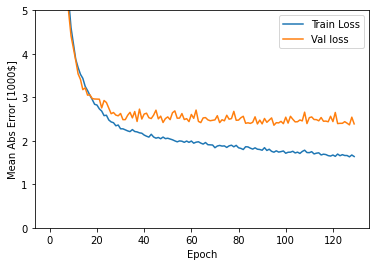

In [8]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

## Test

In [9]:
StopWatch.start("evaluate")
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))
StopWatch.stop("evaluate")

Testing set Mean Abs Error: $2661.79


## Predict


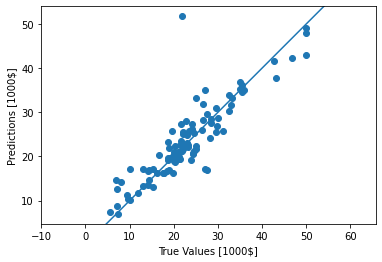

In [10]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100],[-100,100])


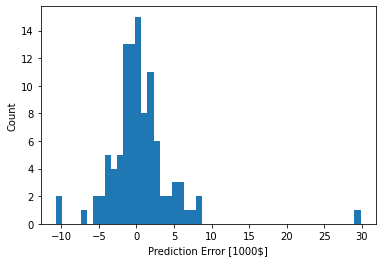

In [11]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
_ = plt.ylabel("Count")

In [12]:
StopWatch.benchmark()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           